In [52]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import missingno as msng

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (8, 6)}, style='whitegrid')

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.shape

(1460, 81)

In [5]:
df.duplicated().sum() # дубликаты отсутствуют

0

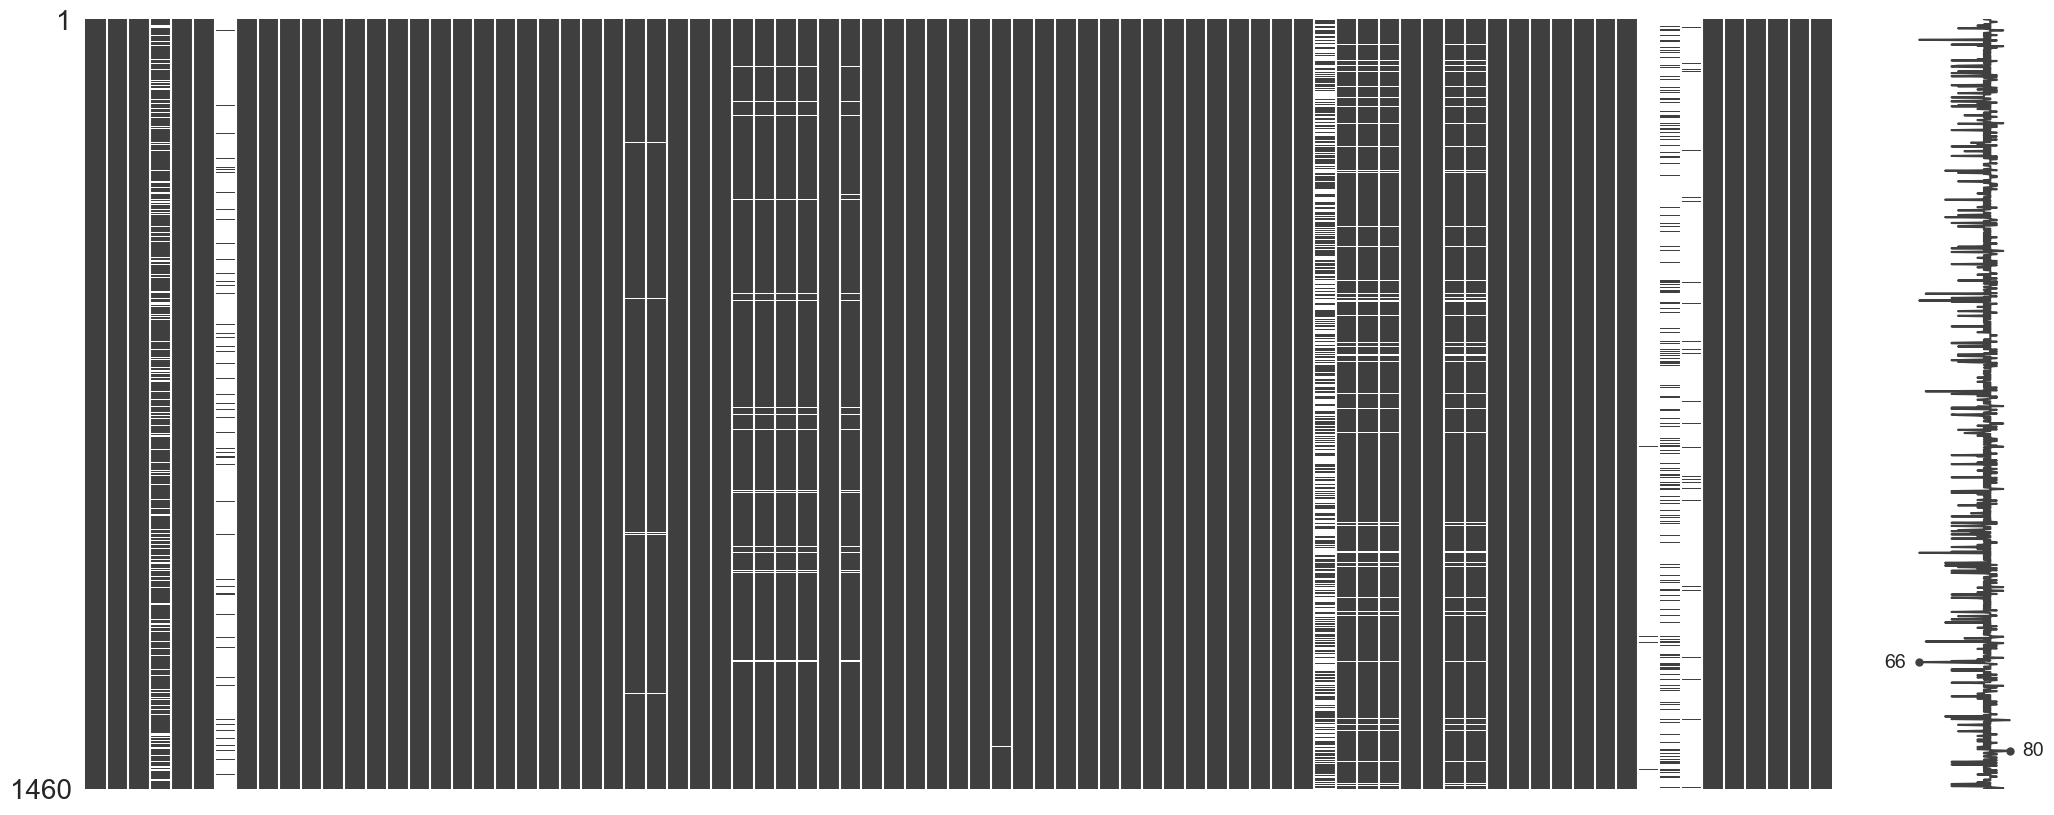

In [6]:
msng.matrix(df); # в датасете есть пропущенные значения

In [7]:
df.isnull().sum()[df.isnull().sum() > 0] # в данных полях есть пропущенные значения

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

В данном датасате 1460 наблюдений, очень много пропущенных заначений (более 50%) в полях: 
Alley (тип доступа к переулку),
PoolQC (качество бассейна),
Fence (качество забора), 
MiscFeature (разные функции, не вошедшие в другие категории) и
FireplaceQu (качество камина).

Данные слобца лучше удалить.

In [8]:
df.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'], inplace=True)

In [9]:
df.isnull().sum()[df.isnull().sum() > 0] # оставшиеся поля с пропусками

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [10]:
columns_nan = df.isnull().sum()[df.isnull().sum() > 0].index # данные поля необходимо заполнить
len(columns_nan) 

14

In [11]:
df.select_dtypes(include=np.number).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1452 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

In [12]:
columns_numeric = df.select_dtypes(include=np.number).columns
columns_numeric

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [13]:
# заполним прпуски в числовых колонках медианным значением
for col_nan in columns_nan:
    if col_nan in columns_numeric:
        df[col_nan].fillna(df[col_nan].median(),inplace=True)

In [14]:
df.select_dtypes(include=np.number).info() # все пропуски заполнены

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1460 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

In [15]:
 df.GarageYrBlt = df. GarageYrBlt.astype('int') # изменим тип данных на int для года

In [16]:
df.isnull().sum()[df.isnull().sum() > 0] # пропущенные категориальные поля

MasVnrType       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64

In [17]:
columns_nan_object = df.isnull().sum()[df.isnull().sum() > 0].index

In [18]:
for col_nan in columns_nan_object:
    print(df[col_nan].unique())
    print(col_nan, 'mode =', df[col_nan].mode()[0])
    print()
    

['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
MasVnrType mode = None

['Gd' 'TA' 'Ex' nan 'Fa']
BsmtQual mode = TA

['TA' 'Gd' nan 'Fa' 'Po']
BsmtCond mode = TA

['No' 'Gd' 'Mn' 'Av' nan]
BsmtExposure mode = No

['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtFinType1 mode = Unf

['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
BsmtFinType2 mode = Unf

['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
Electrical mode = SBrkr

['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
GarageType mode = Attchd

['RFn' 'Unf' 'Fin' nan]
GarageFinish mode = Unf

['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
GarageQual mode = TA

['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
GarageCond mode = TA



In [19]:
df.MasVnrType.replace('None', np.nan, inplace=True)

In [20]:
df.MasVnrType.isnull().sum() # в MasVnrType (тип каменной кладки) более 50% пропусков

872

In [21]:
df.drop(columns=['MasVnrType'], inplace=True)
columns_nan_object = df.isnull().sum()[df.isnull().sum() > 0].index

In [22]:
for col_nan in columns_nan_object:
    df[col_nan].fillna(df[col_nan].mode()[0], inplace=True)

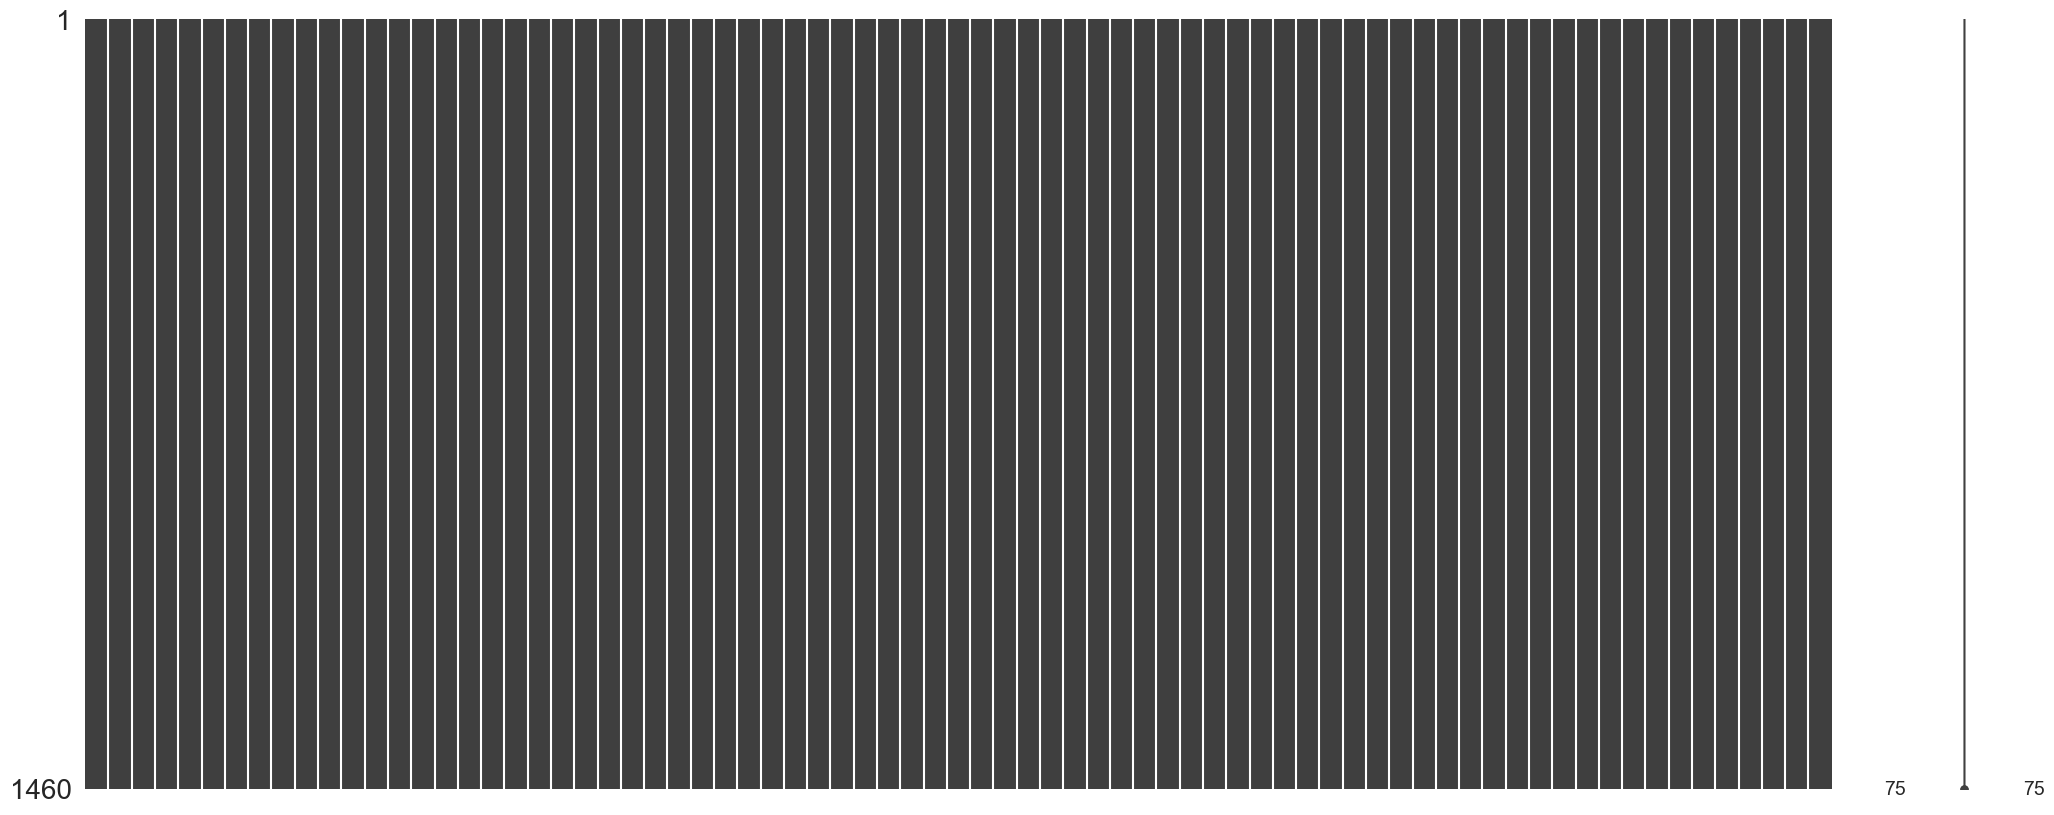

In [23]:
msng.matrix(df); # все пропущенные значения заполнены

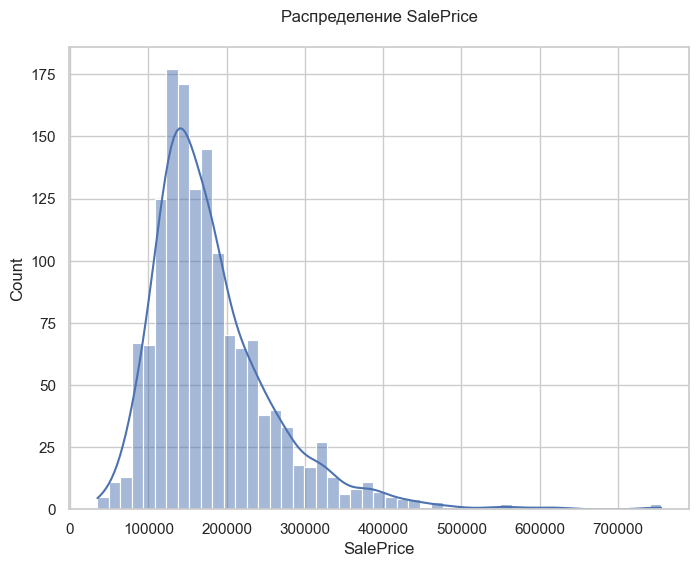

In [24]:
sns.histplot(df.SalePrice, kde=True)
plt.title('Распределение SalePrice\n')
plt.show()

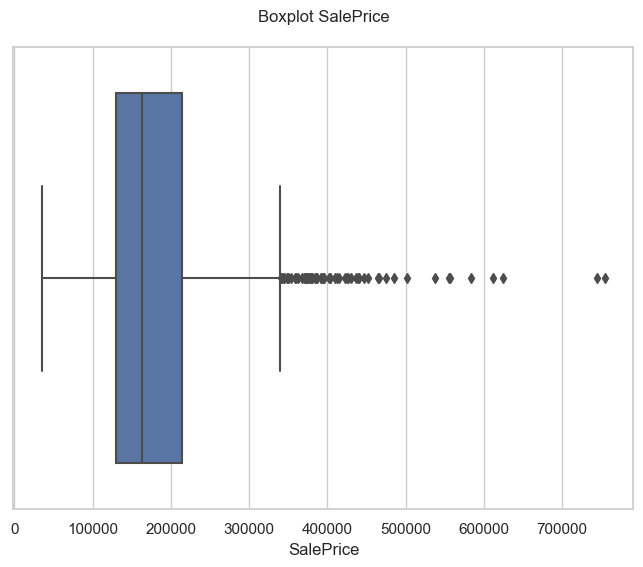

In [25]:
sns.boxplot(df.SalePrice)
plt.title('Boxplot SalePrice\n')
plt.show()

В значениях SalesPrice присутствуют значительные выбросы.

In [26]:
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [27]:
# Вычисление Z-score для столбца "SalePrice"
z = np.abs(stats.zscore(df['SalePrice']))

# Установка порогового значения Z-score
threshold = 3

# Выявление выбросов на основе Z-score
outliers = df['SalePrice'][z > threshold]
outliers

58      438780
178     501837
185     475000
349     437154
389     426000
440     555000
473     440000
496     430000
527     446261
591     451950
664     423000
691     755000
769     538000
798     485000
803     582933
898     611657
1046    556581
1142    424870
1169    625000
1182    745000
1243    465000
1373    466500
Name: SalePrice, dtype: int64

In [28]:
df.drop(outliers.index, inplace=True)

In [29]:
df.reset_index(drop=True, inplace=True)

In [30]:
df.shape

(1438, 75)

In [31]:
correlation_matrix = df.corr()

In [32]:
correlation_matrix.SalePrice

Id              -0.028112
MSSubClass      -0.082756
LotFrontage      0.322352
LotArea          0.253476
OverallQual      0.796343
OverallCond     -0.069833
YearBuilt        0.557339
YearRemodAdd     0.536864
MasVnrArea       0.418957
BsmtFinSF1       0.341000
BsmtFinSF2      -0.004591
BsmtUnfSF        0.216787
TotalBsmtSF      0.582442
1stFlrSF         0.572255
2ndFlrSF         0.287319
LowQualFinSF    -0.060149
GrLivArea        0.670485
BsmtFullBath     0.231469
BsmtHalfBath    -0.026684
FullBath         0.553524
HalfBath         0.276652
BedroomAbvGr     0.172871
KitchenAbvGr    -0.145244
TotRmsAbvGrd     0.487621
Fireplaces       0.465635
GarageYrBlt      0.480455
GarageCars       0.651158
GarageArea       0.626092
WoodDeckSF       0.330921
OpenPorchSF      0.313403
EnclosedPorch   -0.140363
3SsnPorch        0.061720
ScreenPorch      0.092677
PoolArea         0.036829
MiscVal         -0.018489
MoSold           0.081094
YrSold          -0.019633
SalePrice        1.000000
Name: SalePr

In [33]:
correlation_matrix.SalePrice[correlation_matrix.SalePrice > 0.7] # сильные корреляции

OverallQual    0.796343
SalePrice      1.000000
Name: SalePrice, dtype: float64

In [34]:
correlation_matrix.SalePrice[correlation_matrix.SalePrice < -0.70]

Series([], Name: SalePrice, dtype: float64)

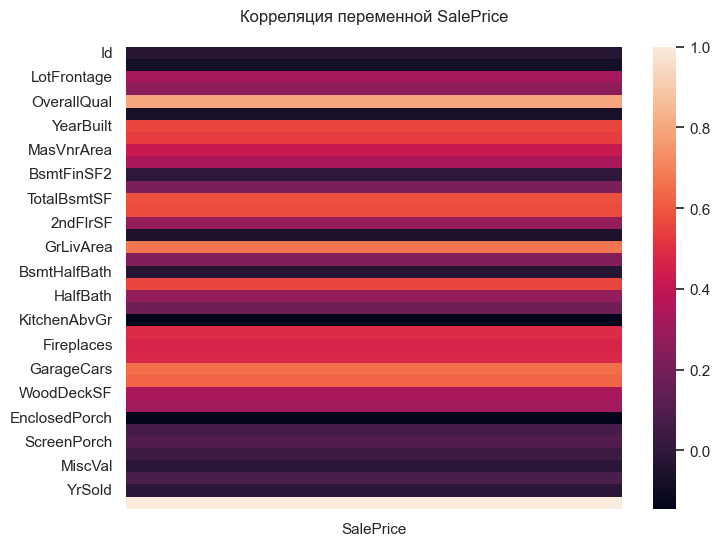

In [35]:
sns.heatmap(correlation_matrix[['SalePrice']], annot=False)
plt.title('Корреляция переменной SalePrice\n');

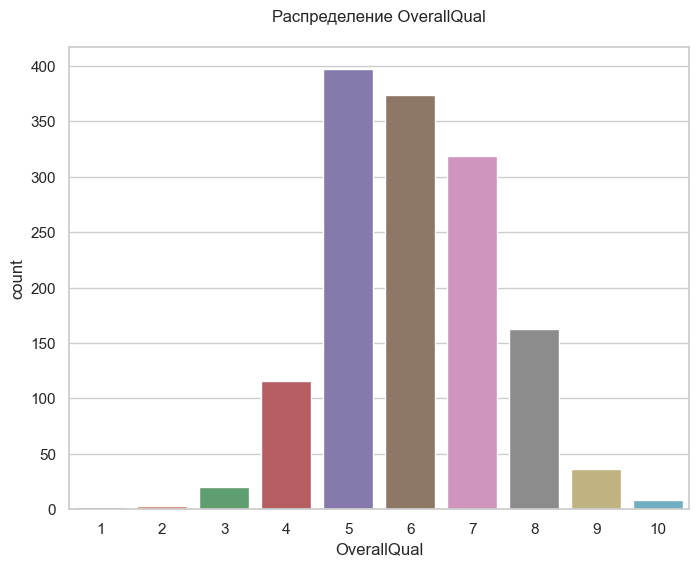

In [36]:
sns.countplot(df.OverallQual)  # OverallQual общее качество материала и отделки
plt.title('Распределение OverallQual\n');

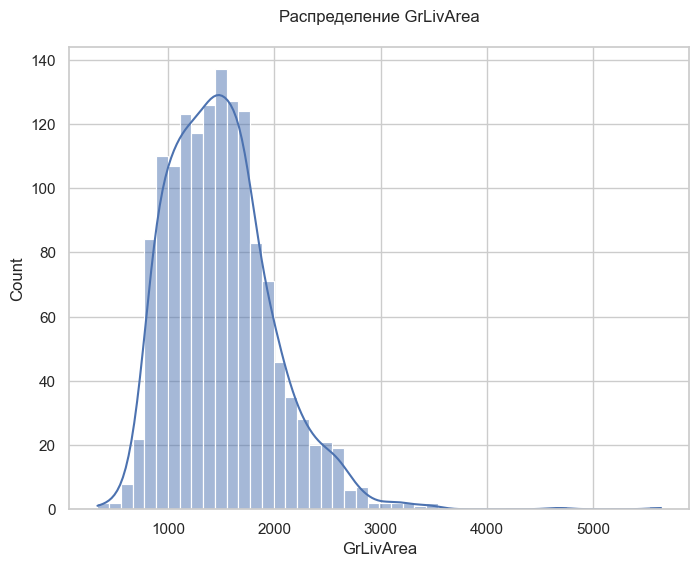

In [37]:
sns.histplot(df.GrLivArea, kde=True) # жилая площадь над землей, квадратные футы.
plt.title('Распределение GrLivArea\n');

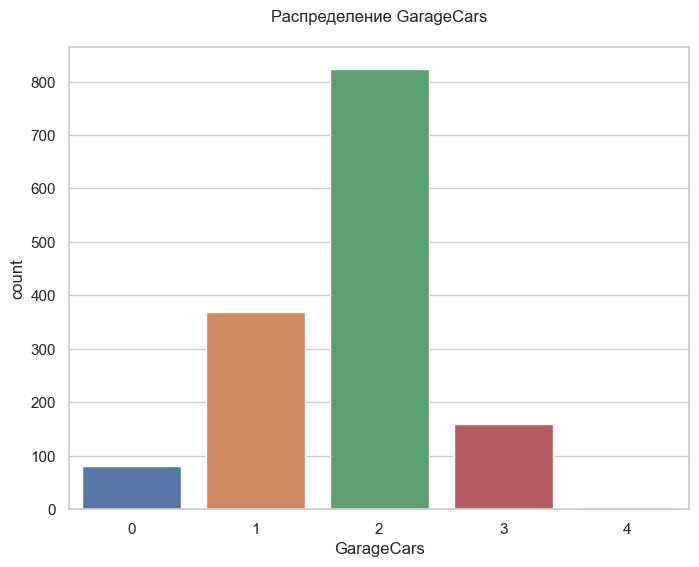

In [38]:
sns.countplot(df.GarageCars) # размер гаража по вместимости автомобилей
plt.title('Распределение GarageCars\n');

In [39]:
cor_columns = correlation_matrix.SalePrice[(correlation_matrix.SalePrice).abs() > 0.6].index
cor_columns

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'SalePrice'], dtype='object')

In [40]:
correlation_matrix[(correlation_matrix > 0.6) | (correlation_matrix < -0.6)][['OverallQual', 'GrLivArea', 'GarageCars', 
                                                                              'GarageArea', 'SalePrice']]

,OverallQual,GrLivArea,GarageCars,GarageArea,SalePrice
Id,NaN,NaN,NaN,NaN,NaN
MSSubClass,NaN,NaN,NaN,NaN,NaN
LotFrontage,NaN,NaN,NaN,NaN,NaN
LotArea,NaN,NaN,NaN,NaN,NaN
OverallQual,1.000000,NaN,NaN,NaN,0.796343
OverallCond,NaN,NaN,NaN,NaN,NaN
YearBuilt,NaN,NaN,NaN,NaN,NaN
YearRemodAdd,NaN,NaN,NaN,NaN,NaN
MasVnrArea,NaN,NaN,NaN,NaN,NaN
BsmtFinSF1,NaN,NaN,NaN,NaN,NaN


SalePrice : цена продажи недвижимости в долларах

GrLivArea : жилая площадь над землей, квадратные футы

GarageCars : размер гаража по вместимости автомобилей

GarageArea : размер гаража в квадратных футах

OverallQual : общее качество материала и отделки.

Переменные, которые оказывают наибольшее влияние на цену продажи, также есть сильная корреляция (более 0.8) между GarageArea и GarageCars.

Диаграммы рассеивания и распределений наиболее коррелирующих переменных (более 0.6)



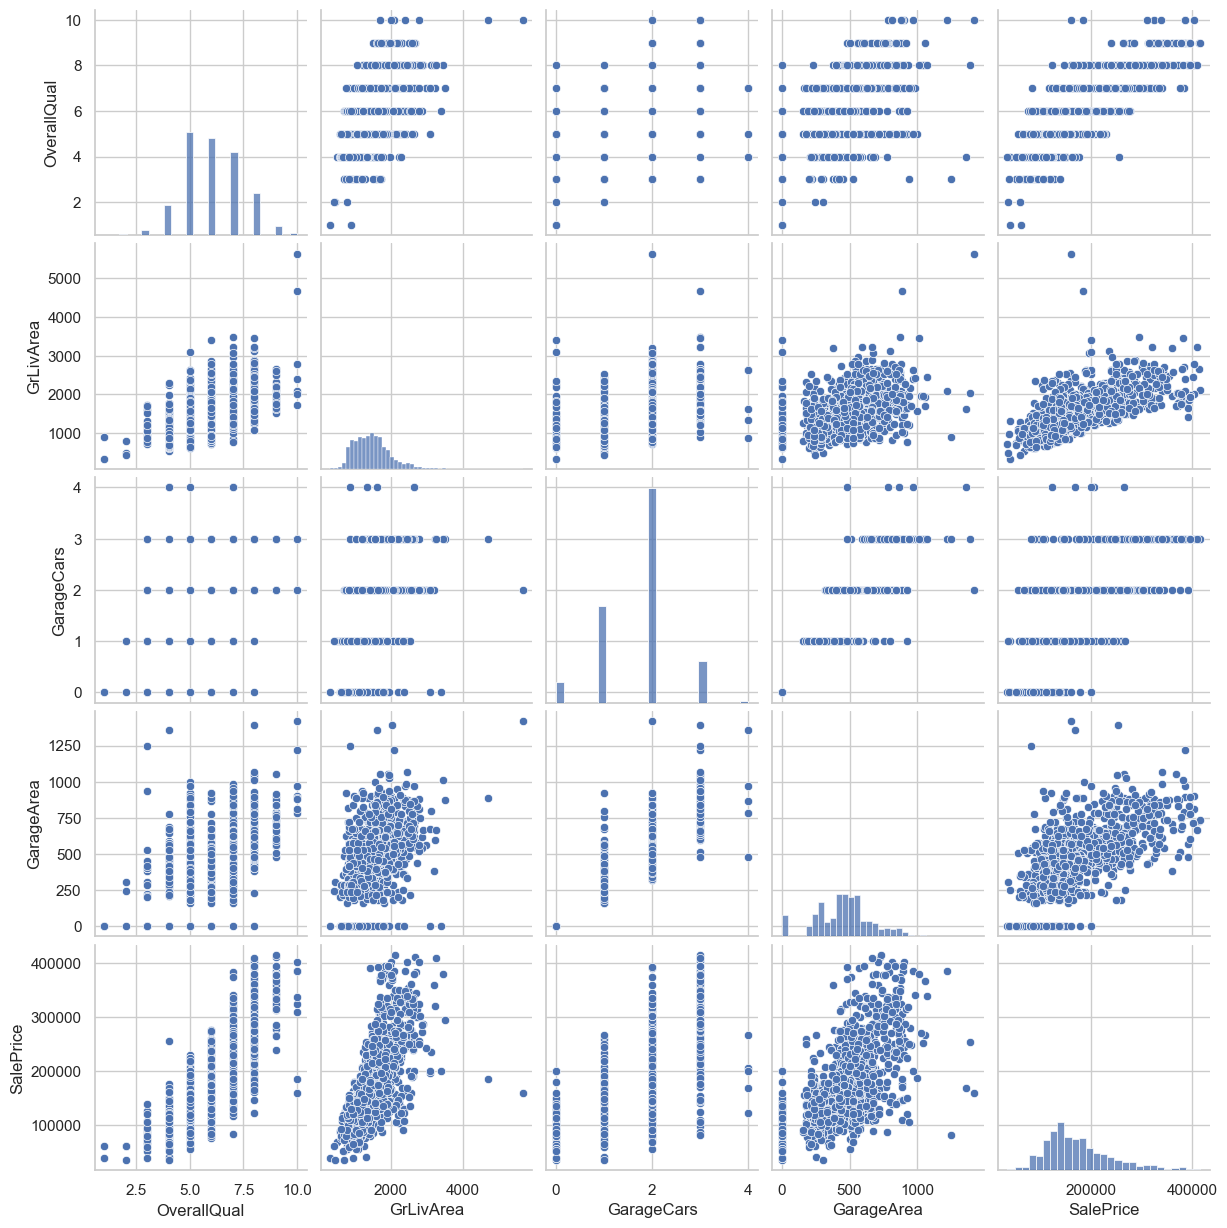

In [41]:
print('Диаграммы рассеивания и распределений наиболее коррелирующих переменных (более 0.6)\n')
sns.pairplot(df[cor_columns])
plt.show()

In [42]:
le = LabelEncoder()

for col in df.select_dtypes(include='object').columns:
    if len(df[col].unique()) > 2:
        df[col] = le.fit_transform(df[col].astype(str))
    else:
        df = pd.get_dummies(df, columns=[col])

In [43]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,YrSold,SaleType,SaleCondition,SalePrice,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,CentralAir_N,CentralAir_Y
0,1,60,3,65.0,8450,3,3,4,0,5,...,2008,8,4,208500,0,1,1,0,0,1
1,2,20,3,80.0,9600,3,3,2,0,24,...,2007,8,4,181500,0,1,1,0,0,1
2,3,60,3,68.0,11250,0,3,4,0,5,...,2008,8,4,223500,0,1,1,0,0,1
3,4,70,3,60.0,9550,0,3,0,0,6,...,2006,8,0,140000,0,1,1,0,0,1
4,5,60,3,84.0,14260,0,3,2,0,15,...,2008,8,4,250000,0,1,1,0,0,1


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 78 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1438 non-null   int64  
 1   MSSubClass        1438 non-null   int64  
 2   MSZoning          1438 non-null   int32  
 3   LotFrontage       1438 non-null   float64
 4   LotArea           1438 non-null   int64  
 5   LotShape          1438 non-null   int32  
 6   LandContour       1438 non-null   int32  
 7   LotConfig         1438 non-null   int32  
 8   LandSlope         1438 non-null   int32  
 9   Neighborhood      1438 non-null   int32  
 10  Condition1        1438 non-null   int32  
 11  Condition2        1438 non-null   int32  
 12  BldgType          1438 non-null   int32  
 13  HouseStyle        1438 non-null   int32  
 14  OverallQual       1438 non-null   int64  
 15  OverallCond       1438 non-null   int64  
 16  YearBuilt         1438 non-null   int64  


In [45]:
df[["TotalBsmtSF", "GrLivArea", "GarageArea", 
"OpenPorchSF","EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea"]].head()

,TotalBsmtSF,GrLivArea,GarageArea,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
0,856,1710,548,61,0,0,0,0
1,1262,1262,460,0,0,0,0,0
2,920,1786,608,42,0,0,0,0
3,756,1717,642,35,272,0,0,0
4,1145,2198,836,84,0,0,0,0


In [46]:
df['TotalArea'] = df[["TotalBsmtSF", "GrLivArea", "GarageArea", 
"OpenPorchSF","EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea"]].sum(axis=1) # общая площадь недвижимости

In [47]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,SaleType,SaleCondition,SalePrice,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,CentralAir_N,CentralAir_Y,TotalArea
0,1,60,3,65.0,8450,3,3,4,0,5,...,8,4,208500,0,1,1,0,0,1,3175
1,2,20,3,80.0,9600,3,3,2,0,24,...,8,4,181500,0,1,1,0,0,1,2984
2,3,60,3,68.0,11250,0,3,4,0,5,...,8,4,223500,0,1,1,0,0,1,3356
3,4,70,3,60.0,9550,0,3,0,0,6,...,8,0,140000,0,1,1,0,0,1,3422
4,5,60,3,84.0,14260,0,3,2,0,15,...,8,4,250000,0,1,1,0,0,1,4263


In [48]:
df.to_csv('cleaned_house_prices.csv')